## <font color='darkblue'>POS Tagging - An Overview</font>
([article source](https://www.kaggle.com/tanyadayanand/pos-tagging-using-rnn)) <font size='3ptx'>**The process of classifying words into their [parts of speech](https://en.wikipedia.org/wiki/Part_of_speech) and labeling them accordingly is known as part-of-speech tagging, or simply POS-tagging.**</font>

The [**NLTK library**](https://www.nltk.org/) has a number of corpora which contains word and its POS tag. The following table provide information about each tag:
![1.png](images/1.PNG)
<br/>

### <font color='darkgreen'>Notebook layout</font>
1. <font size='3ptx'>[**Preprocess data**](#sect1)</font>
2. <font size='3ptx'>[**Vanilla RNN**](#sect2)</font>
3. <font size='3ptx'>[**LSTM**](#sect3)</font>
5. GRU
6. Bidirectional LSTM
7. Model Evaluation

In [1]:
#!pip install nltk
#!pip install seaborn
#!pip install gensim
#!pip install keras

In [2]:
import os
import sys
import subprocess

# subprocess = subprocess.Popen("pip freeze", shell=True, stdout=subprocess.PIPE)
# print(subprocess.stdout.read().decode('utf8'))
print(sys.version_info)
print(sys.executable)

sys.version_info(major=3, minor=9, micro=2, releaselevel='final', serial=0)
/usr/local/google/home/johnkclee/Github/ml_articles/env/bin/python


In [3]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import nltk

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
from nltk.tokenize import word_tokenize as nltk_word_tokenize

import seaborn as sns

from gensim.models import KeyedVectors
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<a id='sect1'></a>
## <font color='darkblue'>1. Preprocess data</font>
Here we will going to load in datas and explore them.

### <font color='darkgreen'>Load data</font>

In [4]:
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')
  
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

[nltk_data] Downloading package treebank to
[nltk_data]     /usr/local/google/home/johnkclee/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /usr/local/google/home/johnkclee/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /usr/local/google/home/johnkclee/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/local/google/home/johnkclee/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [5]:
tagged_sentences[7]

[('A', 'DET'),
 ('Lorillard', 'NOUN'),
 ('spokewoman', 'NOUN'),
 ('said', 'VERB'),
 (',', '.'),
 ('``', '.'),
 ('This', 'DET'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('old', 'ADJ'),
 ('story', 'NOUN'),
 ('.', '.')]

### <font color='darkgreen'>Divide data in words (X) and tags (y)</font>
We have to preprocess the raw data into `X` (features) and `y` (labels) for ML training. Since this is a many-to-many problem, each data point will be a different sentence of the corpora.
* Each data point will have multiple words in the input sequence. This is what we will refer to as `X`.
* Each word will have its correpsonding tag in the output sequence. This what we will refer to as `y`.

Sample dataset:

| X | y |
| --- | --- |
|Mr. Vinken is chairman of Elsevier | NOUN NOUN VERB NOUN ADP NOUN |
|We have no useful information | PRON VERB DET ADJ NOUN |

In [6]:
X = [] # store input sequence
y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    y.append(y_sentence)

In [7]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in y for word in sentence]))

In [8]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [9]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [10]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


### <font color='darkgreen'>Vectorise X and y</font>

#### Encode X and Y to integer values
We'll use the <font color='blue'>Tokenizer()</font> function from Keras library ([Keras Text Preprocess](https://keras.io/api/preprocessing/text/)) to encode text sequence to integer sequence

In [11]:
# encode X
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [12]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y)
y_encoded = tag_tokenizer.texts_to_sequences(y)

In [13]:
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



### <font color='darkgreen'>Pad sequences</font>
The next step after encoding the data is to **define the sequence lengths**. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a **hyperparameter**.

In [14]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


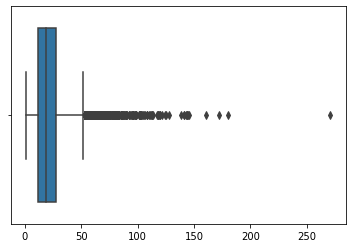

In [15]:
sns.boxplot(lengths)
plt.show()

In [16]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
y_padded = pad_sequences(y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [17]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [18]:
# assign padded sequences to X and Y
X, y = X_padded, y_padded

In [19]:
def sentence2vector(sentence):
    # Sentence to token list
    tokens = nltk_word_tokenize(sentence)
    
    # Encode token list
    X_encoded = word_tokenizer.texts_to_sequences([tokens])
    
    # Pad the sequence
    X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
    
    return X_padded, tokens

In [20]:
# How we translate a sentence into feature vector (X)
X_padded, tokens = sentence2vector("This is an interesting sentence.")
X_padded

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   26,   11,   34, 1602, 3586,
           3]], dtype=int32)

### <font color='darkgreen'>Word embeddings</font>
Currently, each word and each tag is encoded as an integer.

We'll use a more sophisticated technique to represent the input words (`X`) using what's known as [**word embeddings**](https://en.wikipedia.org/wiki/Word_embedding).

However, to represent each tag in y, we'll simply use [**one-hot encoding**](https://en.wikipedia.org/wiki/One-hot) scheme since there are only 13 tags in the dataset and the [**LSTM**](https://en.wikipedia.org/wiki/Long_short-term_memory) will have no problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:
* **word2vec model:** https://code.google.com/archive/p/word2vec/
* **GloVe model:** https://nlp.stanford.edu/projects/glove/

**We're using the word2vec model for no particular reason.** Both of these are very efficient in representing words. You can try both and see which one works better. Dimensions of a word embedding is: `(VOCABULARY_SIZE, EMBEDDING_DIMENSION)`

### <font color='darkgreen'>Use word embeddings for input sequences (`X`)</font>

In [21]:
# word2vec
import gensim.downloader as api

word2vec = api.load('word2vec-google-news-300')

In [22]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [23]:
# assign word vectors from word2vec model
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        # Keep unknown word to use vector with all valueas as 0
        pass

In [24]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [25]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

#### Use one-hot encoding for output sequences (Y)

In [26]:
# use Keras' to_categorical function to one-hot encode Y
y = to_categorical(y)

In [27]:
# print Y of the first output sequqnce
print(y.shape)

(72202, 100, 13)


### <font color='darkgreen'>Split data in training, validation and tesing sets</font>

In [28]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
RANDOM_STATE = 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [29]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALID_SIZE, random_state=RANDOM_STATE)

In [30]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


Before using [**RNN**](https://en.wikipedia.org/wiki/Recurrent_neural_network), we must make sure the dimensions of the data are what an [**RNN**](https://en.wikipedia.org/wiki/Recurrent_neural_network) expects. In general, an [**RNN**](https://en.wikipedia.org/wiki/Recurrent_neural_network) expects the following shape:
* **Shape of X**: (#samples, #timesteps, #features)
* **Shape of Y**: (#samples, #timesteps, #features)

Now, there can be various variations in the shape that you use to feed an [**RNN**](https://en.wikipedia.org/wiki/Recurrent_neural_network) depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor `X` doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an [**RNN**](https://en.wikipedia.org/wiki/Recurrent_neural_network), and hence there is no need to explicitly mention the third dimension. That's because when you use the [Embedding()](https://keras.io/api/layers/core_layers/embedding/) layer in Keras, you the training data will automatically be converted to `(#samples, #timesteps, #features)` where `#features` will be the embedding dimention (<font color='brown'>and note that the [**Embedding layer**](https://keras.io/api/layers/core_layers/embedding/) is always the very first layer of an [**RNN**](https://en.wikipedia.org/wiki/Recurrent_neural_network)</font>). While using the embedding layer we only need to reshape the data to `(#samples, #timesteps)` which is what we have done. However, note that you'll need to shape it to `(#samples, #timesteps, #features)` in case you don't use the [Embedding()](https://keras.io/api/layers/core_layers/embedding/) layer in Keras.

<a id='sect2'></a>
## <font color='darkblue'>2. Vanilla RNN</font>
* <font size='3ptx'>[**Uninitialised fixed embeddings**](#sect2_1)</font>
* <font size='3ptx'>[**Compile model**](#sect2_2)</font>
* <font size='3ptx'>[**Fix model**](#sect2_3)</font>
* <font size='3ptx'>[**Evaluate RNN Model (embedding not trainable)**](#sect2_4)</font>
* <font size='3ptx'>[**Uninitialised trainable embeddings**](#sect2_5)</font>
* <font size='3ptx'>[**Compile model**](#sect2_6)</font>
* <font size='3ptx'>[**Fix model**](#sect2_7)</font>
* <font size='3ptx'>[**Using pre-trained embedding weights**](#sect2_8)</font>
* <font size='3ptx'>[**Compile model**](#sect2_9)</font>
* <font size='3ptx'>[**Fix model**](#sect2_10)</font>

<a id='sect2_1'></a>
### <font color='darkgreen'>Uninitialised fixed embeddings</font>
First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [31]:
# total number of tags
NUM_CLASSES = y.shape[2]

In [32]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [33]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          17834700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 64)           23360     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 13)           845       
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


<a id='sect2_2'></a>
### <font color='darkgreen'>Compile model</font>
Here we trained the model by:
* Loss function: [Categorical Cross Entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)
* Optimizer: [Adam](https://keras.io/api/optimizers/adam/)
* Metrics: [Accuracy](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class)

In [34]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [35]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          17834700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 64)           23360     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 13)           845       
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


<a id='sect2_3'></a>
### <font color='darkgreen'>Fit Model</font>

In [36]:
BATCH_SIZE = 128
EPOCHS = 10


rnn_training = rnn_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(X_validation, y_validation)
)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpkmlnjlfe.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpkmlnjlfe.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
408/408 [==============================] - 21s 25ms/step - loss: 0.7341 - acc: 0.8088 - val_loss: 0.3260 - val_acc: 0.9018
Epoch 2/10
408/408 [==============================] - 9s 23ms/step - loss: 0.2962 - acc: 0.9103 - val_loss: 0.2263 - val_acc: 0.9313
Epoch 3/10
408/408 [==============================] - 9s 23ms/step - loss: 0.2149 - acc: 0.9340 - val_loss: 0.1837 - val_acc: 0.9

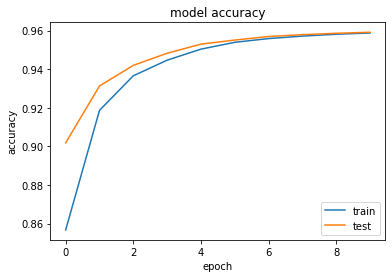

In [37]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

<a id='sect2_4'></a>
### <font color='darkgreen'>Evaluate RNN Model (embedding not trainable)</font>
Here will demonstrate how to make prediction based on given sentence from trained model:

In [38]:
# Translate sentence into feature fectors
X_feats, tokens = sentence2vector("This is an interesting sentence.")
X_feats.shape

(1, 100)

In [39]:
# Prediction
y_pred_tmp = rnn_model.predict(X_feats)
print(y_pred_tmp.shape)

(1, 100, 13)


In [40]:
# Handle padding issue
y_pred = []
for i in range(1, len(tokens)+1):
    y_pred.append(np.argmax(y_pred_tmp[0][-i]))
    
y_pred = y_pred[::-1]
y_pred

[5, 2, 5, 6, 2, 3]

In [41]:
# Output result
for _y, t in zip(y_pred, tokens):
    print(f"{t}/{tag_tokenizer.index_word[_y]}")

This/det
is/verb
an/det
interesting/adj
sentence/verb
./.


Now we know above process, let's wrap this process in a function:

In [42]:
def get_pos_of_sentence(sentence, model):
    # 1) Sentence to feature vector
    _X_test, tokens = sentence2vector(sentence)
    # 2) Prediction
    y_pred_tmp = model.predict(_X_test)
    # 3) Handle padding issue
    y_pred = []
    for i in range(1, len(tokens)+1):
        y_pred.append(np.argmax(y_pred_tmp[0][-i]))
    
    y_pred = list(map(lambda e: tag_tokenizer.index_word[e], y_pred[::-1]))
    
    # Output result
    return tokens, y_pred

In [43]:
tokens, y_pred = get_pos_of_sentence(
    "Fun thing is that I don't know where the rest room is.", 
    rnn_model
)
for t, pos in zip(tokens, y_pred):
    print(f"{t}/{pos}")

Fun/adp
thing/noun
is/verb
that/adp
I/pron
do/verb
n't/adv
know/verb
where/adv
the/det
rest/noun
room/verb
is/verb
./.


<a id='sect2_5'></a>
### <font color='darkgreen'>Uninitialised trainable embeddings</font>
This time, we use RNN with embedding layer as trainable:

In [44]:
# create architecture
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

<a id='sect2_6'></a>
### <font color='darkgreen'>Compile Model</font>

In [45]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [46]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          17834700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 13)           845       
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


<a id='sect2_7'></a>
### <font color='darkgreen'>Fit Model</font> ([back](#sect2))

In [ ]:
rnn_training = rnn_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_validation, y_validation)
)

Epoch 1/10
408/408 [==============================] - 36s 87ms/step - loss: 0.4997 - acc: 0.8867 - val_loss: 0.0410 - val_acc: 0.9878
Epoch 2/10
143/408 [=========>....................] - ETA: 22s - loss: 0.0340 - acc: 0.9899

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

<a id='sect2_8'></a>
### <font color='darkgreen'>Using pre-trained embedding weights</font> ([back](#sect2))

In [ ]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

<a id='sect2_9'></a>
### <font color='darkgreen'>Compile model</font> ([back](#sect2))

In [ ]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [ ]:
# check summary of the model
rnn_model.summary()

<a id='sect2_10'></a>
### <font color='darkgreen'>Fix Model</font> ([back](#sect2))

In [ ]:
rnn_training = rnn_model.fit(
    X_train, 
    y_train,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_validation, y_validation)
)

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

<a id='sect3'></a>
## <font color='darkblue'>3. LSTM</font>
We'll use pre-trained word embeddings in following models and allow them to be updated as well.
1. <font size='3ptx'>[**Create model architecture**](#sect3_1)</font>
2. <font size='3ptx'>[**Compile Model**](#sect3_2)</font>

<a id='sect3_1'></a>
### <font color='darkgreen'>Create model architecture</font>

In [ ]:
# create architecture
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))

lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

<a id='sect3_2'></a>
### <font color='darkgreen'>Compile Model</font>

In [ ]:
lstm_model.compile(
    loss = 'categorical_crossentropy',
    optimizer =  'adam',
    metrics   =  ['acc']
)

In [ ]:
lstm_model.summary()

### <font color='darkgreen'>Fit Model</font>

In [ ]:
lstm_training = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_validation, y_validation)
)

In [ ]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [ ]:
tokens, y_pred = get_pos_of_sentence(
    "Fun thing is that I don't know where the rest room is.", 
    lstm_model
)
for t, pos in zip(tokens, y_pred):
    print(f"{t}/{pos}")

## <font color='darkblue'>4. GRU</font>
[**Gated recurrent units**](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate.
* <font size='3ptx'>[**Create model architecture**](#sect4_1)</font>
* <font size='3ptx'>[**Compile model**](#sect4_2)</font>
* <font size='3ptx'>[**Fit model**](#sect4_3)</font>

<a id='sect4_1'></a>
### <font color='darkgreen'>Create model architecture</font>

In [ ]:
# create architecture
gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

<a id='sect4_2'></a>
### <font color='darkgreen'>Compile model</font>

In [ ]:
gru_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
# check summary of model
gru_model.summary()

<a id='sect4_3'></a>
### <font color='darkgreen'>Fit model</font>

In [ ]:
gru_training = gru_model.fit(
    X_train, 
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_validation, y_validation)
)

In [ ]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## <font color='darkblue'>5. Bidirectional LSTM</font>
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.
* <font size='3ptx'>[**Create model architecture**](#sect5_1)</font>
* <font size='3ptx'>[**Compile model**](#sect5_2)</font>
* <font size='3ptx'>[**Fit model**](#sect5_3)</font>

<a id='sect5_1'></a>
### <font color='darkgreen'>Create model architecture</font>

In [ ]:
# create architecture
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

<a id='sect5_2'></a>
### <font color="darkgreen">Compile Model</font>

In [ ]:
bidirect_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
# check summary of model
bidirect_model.summary()

<a id='sect5_3'></a>
### <font color='darkgreen'>Fit Model </font>

In [ ]:
bidirect_training = bidirect_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_validation, y_validation)
)

In [ ]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## <font color='darkblue'>6. Model evaluation</font>

### <font color='darkgreen'>RNN model performance</font>

In [ ]:
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(rnn_loss, rnn_accuracy))

### <font color='darkgreen'>LSTM model performance</font>

In [ ]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(lstm_loss, lstm_accuracy))

### <font color='darkgreen'>Bidirectional LSTM model performance</font>

In [ ]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

## <font color='darkblue'>Supplement</font>
* [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)
* [Kaggle - Using keras models with scikit-learn pipelines](https://www.kaggle.com/residentmario/using-keras-models-with-scikit-learn-pipelines)
* [How to Develop a Bidirectional LSTM For Sequence Classification in Python with Keras](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)